<a href="https://colab.research.google.com/github/VinodhkumarBaskaran/Quora_Tex_mining/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# Kernel.API -- Document 


# to check whether the keneral is imported r not

!ls -lha kaggle.json

# installing 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 65 Jan 28 04:32 kaggle.json


In [3]:
!kaggle competitions files -c quora-insincere-questions-classification
!kaggle competitions download  -c quora-insincere-questions-classification -p /content/kaggle

name                    size  creationDate         
---------------------  -----  -------------------  
embeddings.zip           6GB  2018-10-31 21:30:39  
sample_submission.csv    1MB  2018-10-31 21:30:49  
test.csv                 5MB  2018-10-31 21:30:50  
train.csv              118MB  2018-10-31 21:30:50  
100% 5.95G/5.96G [02:51<00:00, 35.2MB/s]
100% 5.96G/5.96G [02:51<00:00, 37.4MB/s]
  0% 0.00/649k [00:00<?, ?B/s]
100% 649k/649k [00:00<00:00, 213MB/s]
  0% 0.00/2.36M [00:00<?, ?B/s]
100% 2.36M/2.36M [00:00<00:00, 161MB/s]
 99% 54.0M/54.4M [00:00<00:00, 54.4MB/s]
100% 54.4M/54.4M [00:00<00:00, 79.7MB/s]


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
data  = pd.read_csv('/content/kaggle/train.csv.zip', header=0, sep=',', quotechar='"')

In [7]:
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
data['target'].value_counts() /data.shape[0]*100

0    93.812982
1     6.187018
Name: target, dtype: float64

Meteric for checking the accuarcy is F1 score,recall,precision for imbalance data

#Bag of word analysis - Step 1 (Help to understand what kind of words are used frequently)

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

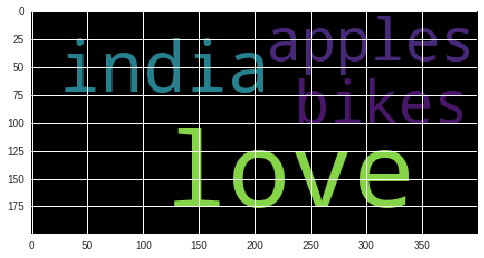

In [12]:
wc=WordCloud().generate('i love india ; i love apples : i love bikes')
plt.imshow(wc)

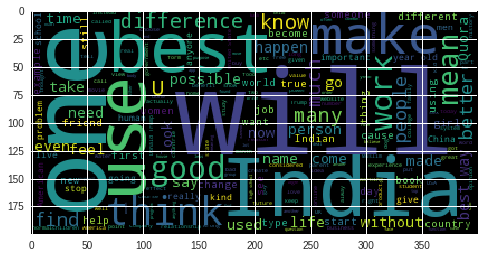

In [13]:
wc=WordCloud().generate(' '.join(data['question_text']))
plt.imshow(wc)

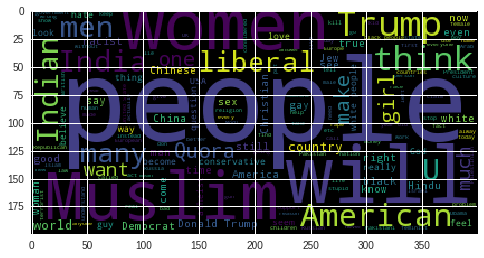

In [15]:
insincere_rows=data[data['target']==1]

wc=WordCloud().generate(' '.join(insincere_rows['question_text']))
plt.imshow(wc)

# Text Cleaning /Transformations

###Step1: Convert the text to lower_case

In [18]:
docs=data['question_text'].str.lower()
docs.head()

0    how did quebec nationalists see their province...
1    do you have an adopted dog, how would you enco...
2    why does velocity affect time? does velocity a...
3    how did otto von guericke used the magdeburg h...
4    can i convert montra helicon d to a mountain b...
Name: question_text, dtype: object

###Regular Expression Techniques

In [19]:
df=pd.DataFrame({'A':['This is a sentance','Sentences can have numbers 1232','Sentences can have special characters liks @vinodh$','#textmining']})
df

,A
0,This is a sentance
1,Sentences can have numbers 1232
2,Sentences can have special characters liks @vi...
3,#textmining


In [26]:
df['A'].str.replace('[a-zA-Z0-9]','') # Remove Alphabets and numbers
df['A'].str.replace('[#$@]','') #Remove certain special characters
df['A'].str.replace('[^a-zA-Z]','')# Retain Alphabets alone
df['A'].str.replace('[^a-zA-Z ]','')# Retain Alphabets amd space


0                                   This is a sentance
1                          Sentences can have numbers 
2    Sentences can have special characters liks vinodh
3                                           textmining
Name: A, dtype: object

###Applying Regular Expression on docs

In [0]:
docs=docs.str.replace('[^a-z ]','')

### Step 2: Remove commonly used words and apply stemming

In [39]:
import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
custom_stop_words=['will']
stopwords.extend(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords=nltk.corpus.stopwords.words('english')
custom_stop_words=['will']
stopwords.extend(custom_stop_words)

### Step: 3  Stemming

It basically remove the suffix and retain the root word

In [53]:
w=['play','played','playing']


stemmer=nltk.stem.PorterStemmer() # different type of stemmer available
stemmer.stem('playing') 


[stemmer.stem(word) for word in w]


# Sometimes stemmer fails for some words

stemmer.stem('organization')

'organ'

###Function for cleaning the data with stemming 

In [0]:
def clean_sentence(text):
    words=text.split(' ')
#     print(words)
    clean_words=[stemmer.stem(word) for word in words if word not in stopwords] #list comprehension with stemmer function 
#     print(clean_words)
    return ' ' .join(clean_words) # Making the words into sentences


####Applying the Cleaning function on the data columns 

In [59]:
docs_clean =docs.apply(clean_sentence)
docs_clean.head()

0              quebec nationalist see provinc nation
1          adopt dog would encourag peopl adopt shop
2      veloc affect time veloc affect space geometri
3           otto von guerick use magdeburg hemispher
4    convert montra helicon mountain bike chang tyre
Name: question_text, dtype: object

###Document Term matrix

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

train,validate=train_test_split(docs_clean,test_size=0.3,random_state=100)

# vectorizer=CountVectorizer()
# vectorizer=CountVectorizer(min_df=100) # It will help us in selecting the col_sum >=100
vectorizer=CountVectorizer(min_df=50) # It will help us in selecting the col_sum >=50 . this helps in reducing the no of features
vectorizer.fit(train)

train_dtm=vectorizer.transform(train)

validate_dtm=vectorizer.transform(validate)

In [80]:
train_dtm

<914285x8052 sparse matrix of type '<class 'numpy.int64'>'
	with 5160600 stored elements in Compressed Sparse Row format>

In [81]:
unique_terms=vectorizer.get_feature_names()
len(unique_terms)

8052

there are 8052 unique in the entire documents

In [0]:
unique_terms[:100] #Printing 100 unique words

In [0]:
rows=914285
columns=8052 
cells=rows* columns
non_zero_cells=5160600  
per=(non_zero_cells/cells)*100

In [85]:
per

0.07009948658340572

To view in the matrix form

In [86]:
df_dtm=pd.DataFrame(train_dtm[:10].toarray(),columns=vectorizer.get_feature_names())
df_dtm

,aa,aaa,aadhaar,aadhar,aakash,aap,aaron,ab,abandon,abbrevi,...,zionism,zionist,zip,zodiac,zombi,zone,zoo,zoolog,zoom,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
train_x=train_dtm
validate_x=validate_dtm




train_y=data.loc[train.index]['target']
validate_y=data.loc[validate.index]['target']

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report
model_dt=DecisionTreeClassifier(max_depth=20)

model_dt.fit(train_x,train_y)
validate_pred=model_dt.predict(validate_x)

print(accuracy_score(validate_y,validate_pred))
print(f1_score(validate_y,validate_pred))

0.9447550894887415
0.3353903779435694


Testing with test data

In [0]:
test  = pd.read_csv('/content/kaggle/test.csv.zip', header=0, sep=',', quotechar='"')

In [0]:
docs_test=test['question_text'].str.lower()
docs_test=docs_test.str.replace('[^a-z ]','')
docs_test_clean =docs_test.apply(clean_sentence)


test_dtm=vectorizer.transform(docs_test_clean)
test_pred=model_dt.predict(test_dtm)


#For getting sample output in csv

In [0]:
sample_submission=pd.read_csv('/content/kaggle/sample_submission.csv.zip', header=0, sep=',', quotechar='"')
submission=pd.DataFrame({'qid' : test['qid'],'prediction':test_pred})
submission.to_csv('submission.csv',index=False)